# Cell-type deconvolution using Tangram

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb


Test with one section, select Donor3_Wound7

Use only top100 genes per cluster.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import os, sys

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


# Load data

### ST data

Load ST data, obs! Load from scratch and then subset for the spots that were filtered in Seurat

In [2]:
input_dir = "../../deconv/inputs/"
output_dir = "../../deconv/results/tangram/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


    
sample = "Donor3_Wound7"
outdir = os.path.join(output_dir,sample)
if not os.path.exists(outdir):
    os.makedirs(outdir)
indir = os.path.join(input_dir,"st_data",sample)   
    

fh = open(os.path.join(indir, "rawdata_path.csv"),"r+")
raw_path = fh.read()
fh.close()
print(raw_path)   
raw_path = raw_path.strip()
  



../../spatial/rawdata//Donor_3_4/P20063_107



In [3]:
adata_st = sc.read_visium(raw_path, library_id = sample)
adata_st.var_names_make_unique()
adata_st

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1749 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
# read in the barcodes
barcodes = pd.read_csv(os.path.join(indir, "barcodes.csv"), header = None)

# subset
adata_st = adata_st[adata_st.obs.index.isin(barcodes[0]),:]
adata_st

View of AnnData object with n_obs × n_vars = 1725 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Load SC data

In [5]:
sc_dir = '../../scRNAseq/results/'
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [6]:

# has normalized counts in .X and counts in raw.X

# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index

In [7]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()


In [8]:
adata_sc.obs['cl.annot'].value_counts()

VE             385
Mast-cell      381
Granular-II    380
Mono-Mac       378
Th             376
FB-II          376
Spinous-I      374
MEL            374
Granular-I     373
Basal-I        368
PC-vSMC        368
FB-IV          367
Mac            367
Spinous-II     367
FB-III         367
Basal-II       366
NK-cell        366
Spinous-III    364
FB-I           352
DC             312
B-cell         292
Basal-III      290
Basal-IV       286
LE             283
LC             237
Mono-DC        235
Schwann        136
Name: cl.annot, dtype: int64

### DEGs

In [9]:
deg_path = os.path.join(input_dir, "sc_data", "degs_top100.txt")
genes = pd.read_csv(deg_path, header=None) 
genes

0
0        KRT1
1       KRT10
2      KRTDAP
3        DMKN
4     LGALS7B
...       ...
1552    CLIC4
1553    ABHD2
1554     BEX3
1555   PDLIM7
1556   PRSS23

[1557 rows x 1 columns]

In [10]:
# check that the genes are in the datasets

print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])


0    1557
dtype: int64
0    1557
dtype: int64


In [11]:
adata_sc.var_names

Index(['RP11-34P13.7', 'RP11-34P13.13', 'RP11-34P13.9', 'RP11-206L10.4',
       'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'RP11-206L10.19',
       'FAM41C',
       ...
       'TCAF2C', 'RP11-148O21.2', 'RP11-90J7.3', 'LINC00333', 'RP11-779M2.1',
       'LINC02169', 'ELSPBP1', 'LINC01258', 'LINC02492', 'TRAV26-1'],
      dtype='object', length=25778)

### Preprocess ST data

Run normalization and QC calculation

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


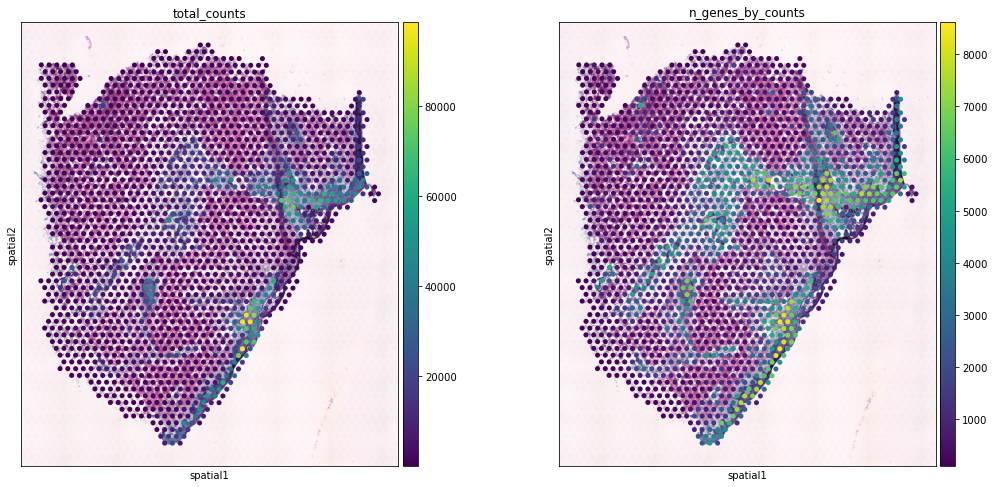

In [12]:
sc.pp.calculate_qc_metrics(adata_st, inplace=True)
adata_st.raw = adata_st
sc.pp.normalize_per_cell(adata_st)

plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_st, img_key="hires", color=["total_counts", "n_genes_by_counts"], library_id = sample)



In [13]:
# same normalization for SC data
sc.pp.normalize_per_cell(adata_sc)



## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the top 100 DEGs per single cell cluster. Other common gene sets are variable genes in SC data, intersection of the highly variable genes from both datasets.

In [14]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1555 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:21007 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on the GPU. However, it's also possible to train it on the CPU, it will just be slower.

In [15]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    scale=False,
#    target_count=adata_st.obs.cell_count.sum(),
#    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    density_prior='rna_count_based',
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1555 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.249, KL reg: 0.000
Score: 0.494, KL reg: 0.001
Score: 0.500, KL reg: 0.001
Score: 0.501, KL reg: 0.001
Score: 0.502, KL reg: 0.001
Score: 0.502, KL reg: 0.001
Score: 0.503, KL reg: 0.001
Score: 0.503, KL reg: 0.001
Score: 0.503, KL reg: 0.001
Score: 0.503, KL reg: 0.001


INFO:root:Saving results..


In [16]:
ad_map

AnnData object with n_obs × n_vars = 9120 × 1725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [17]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [18]:
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"tangram_top100_cpm.csv"))

In [19]:
# add predictions to adata_st

adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [20]:
celltypes = adata_sc.obs['cl.annot'].unique()
celltypes = sorted(celltypes)

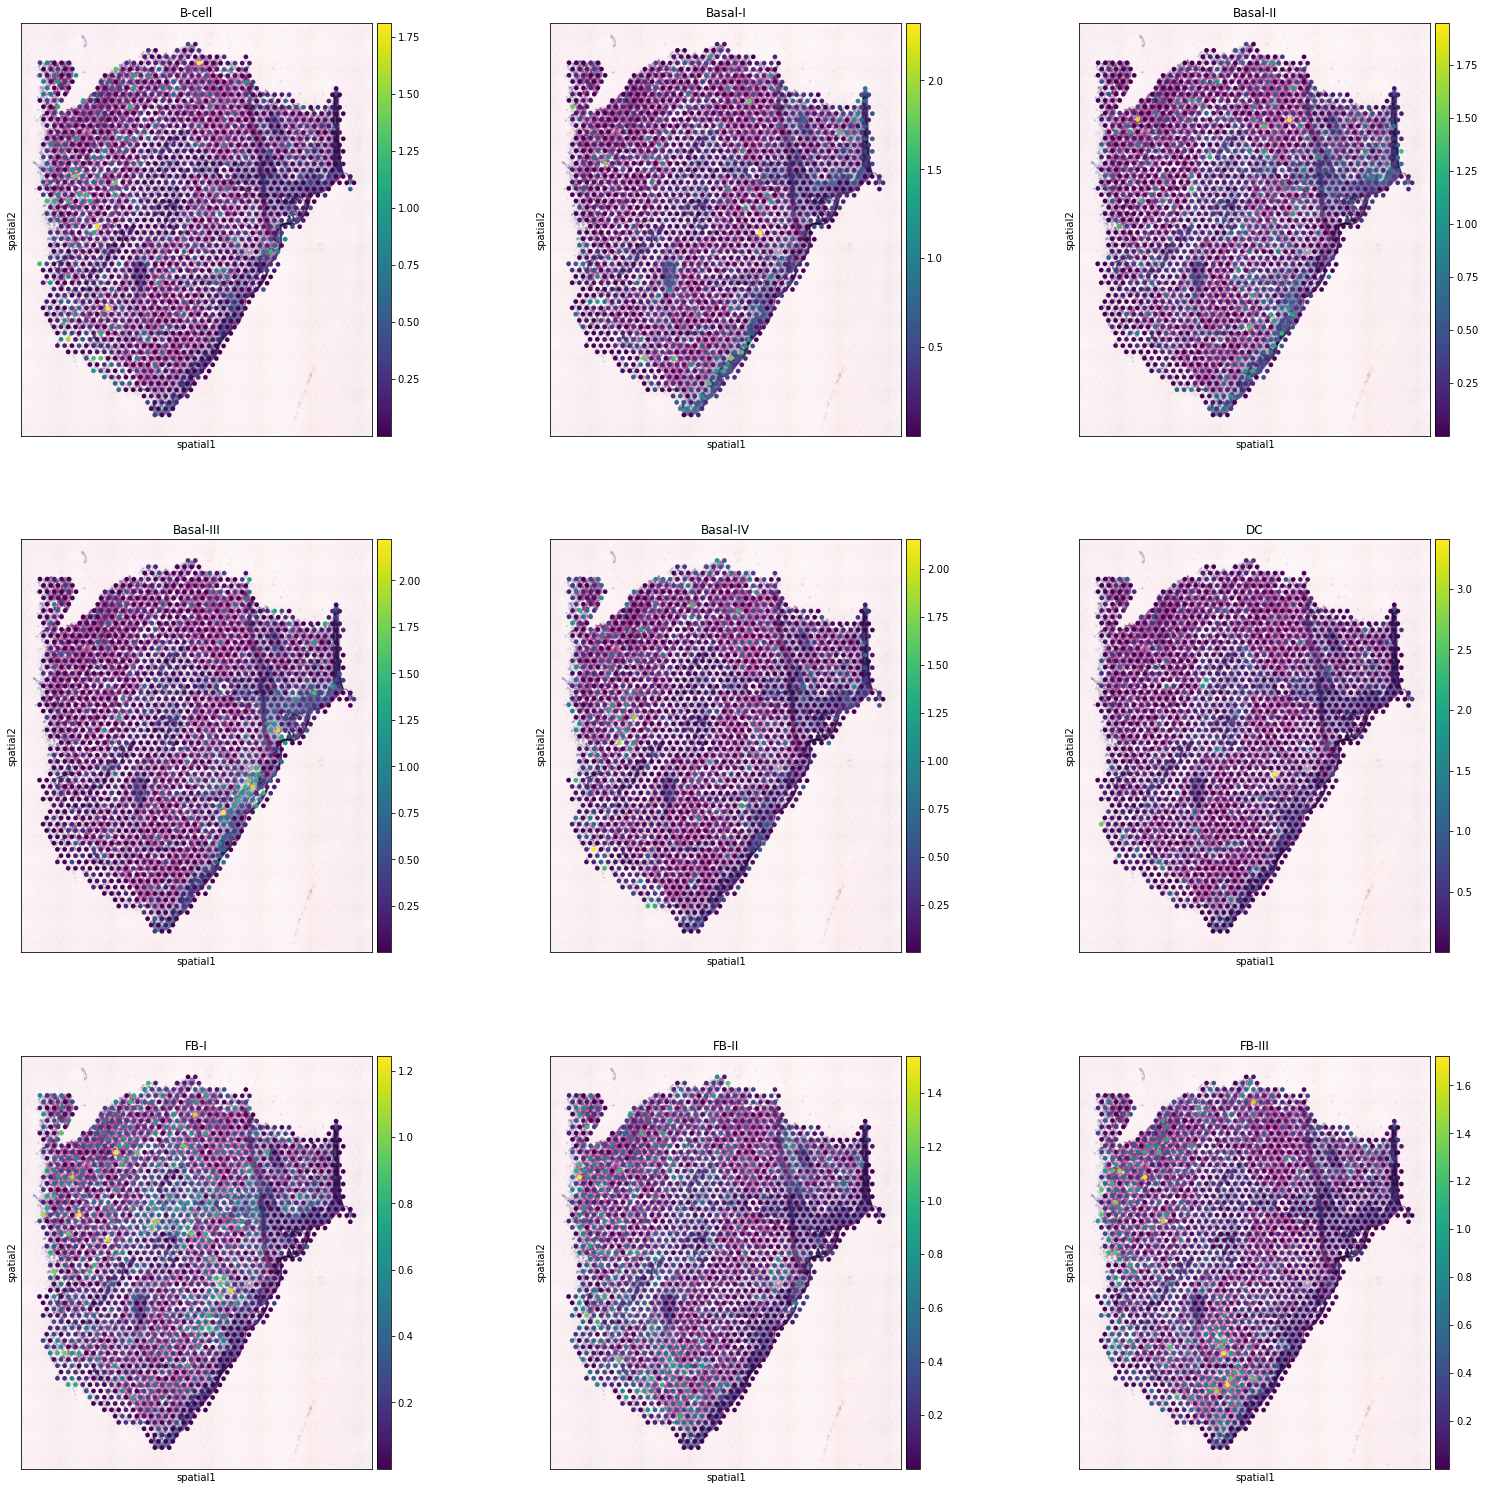

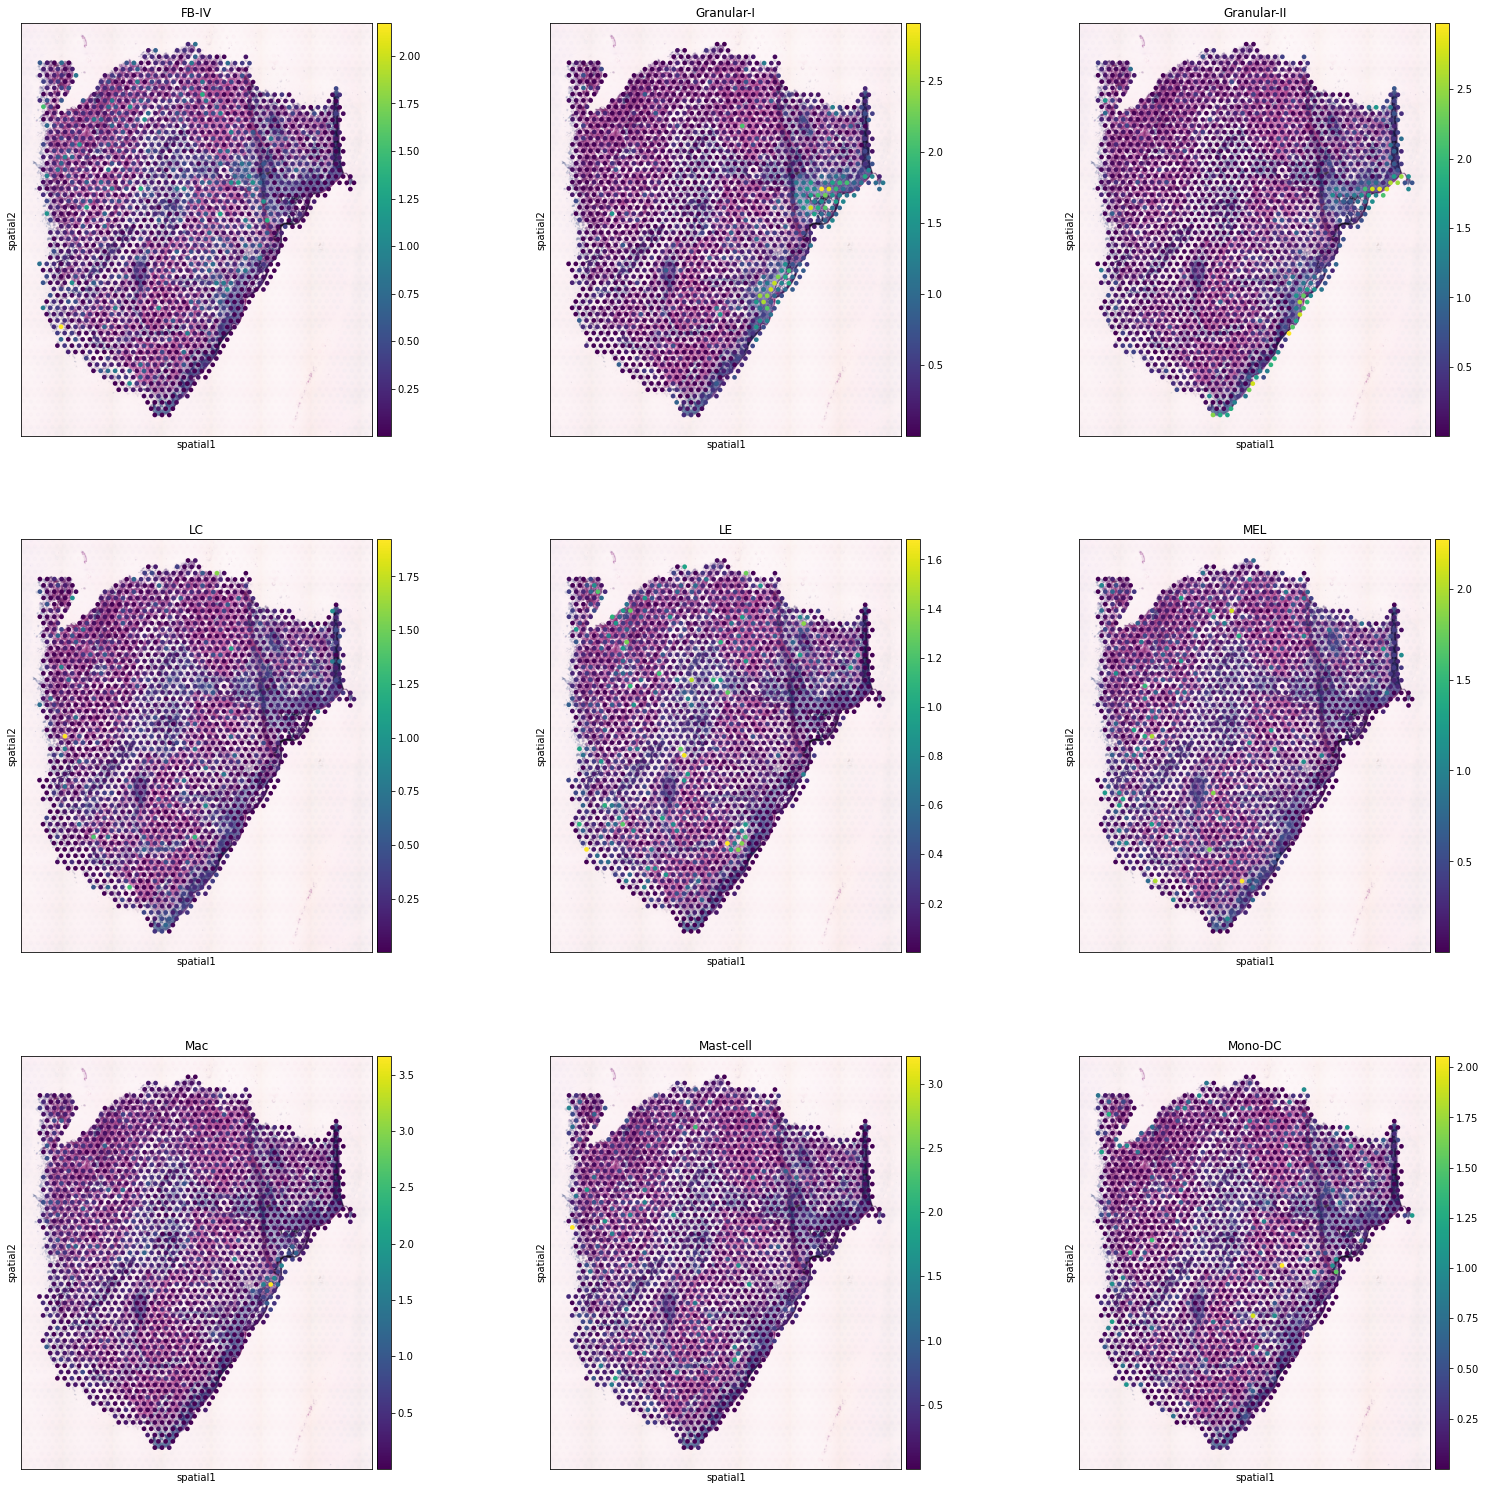

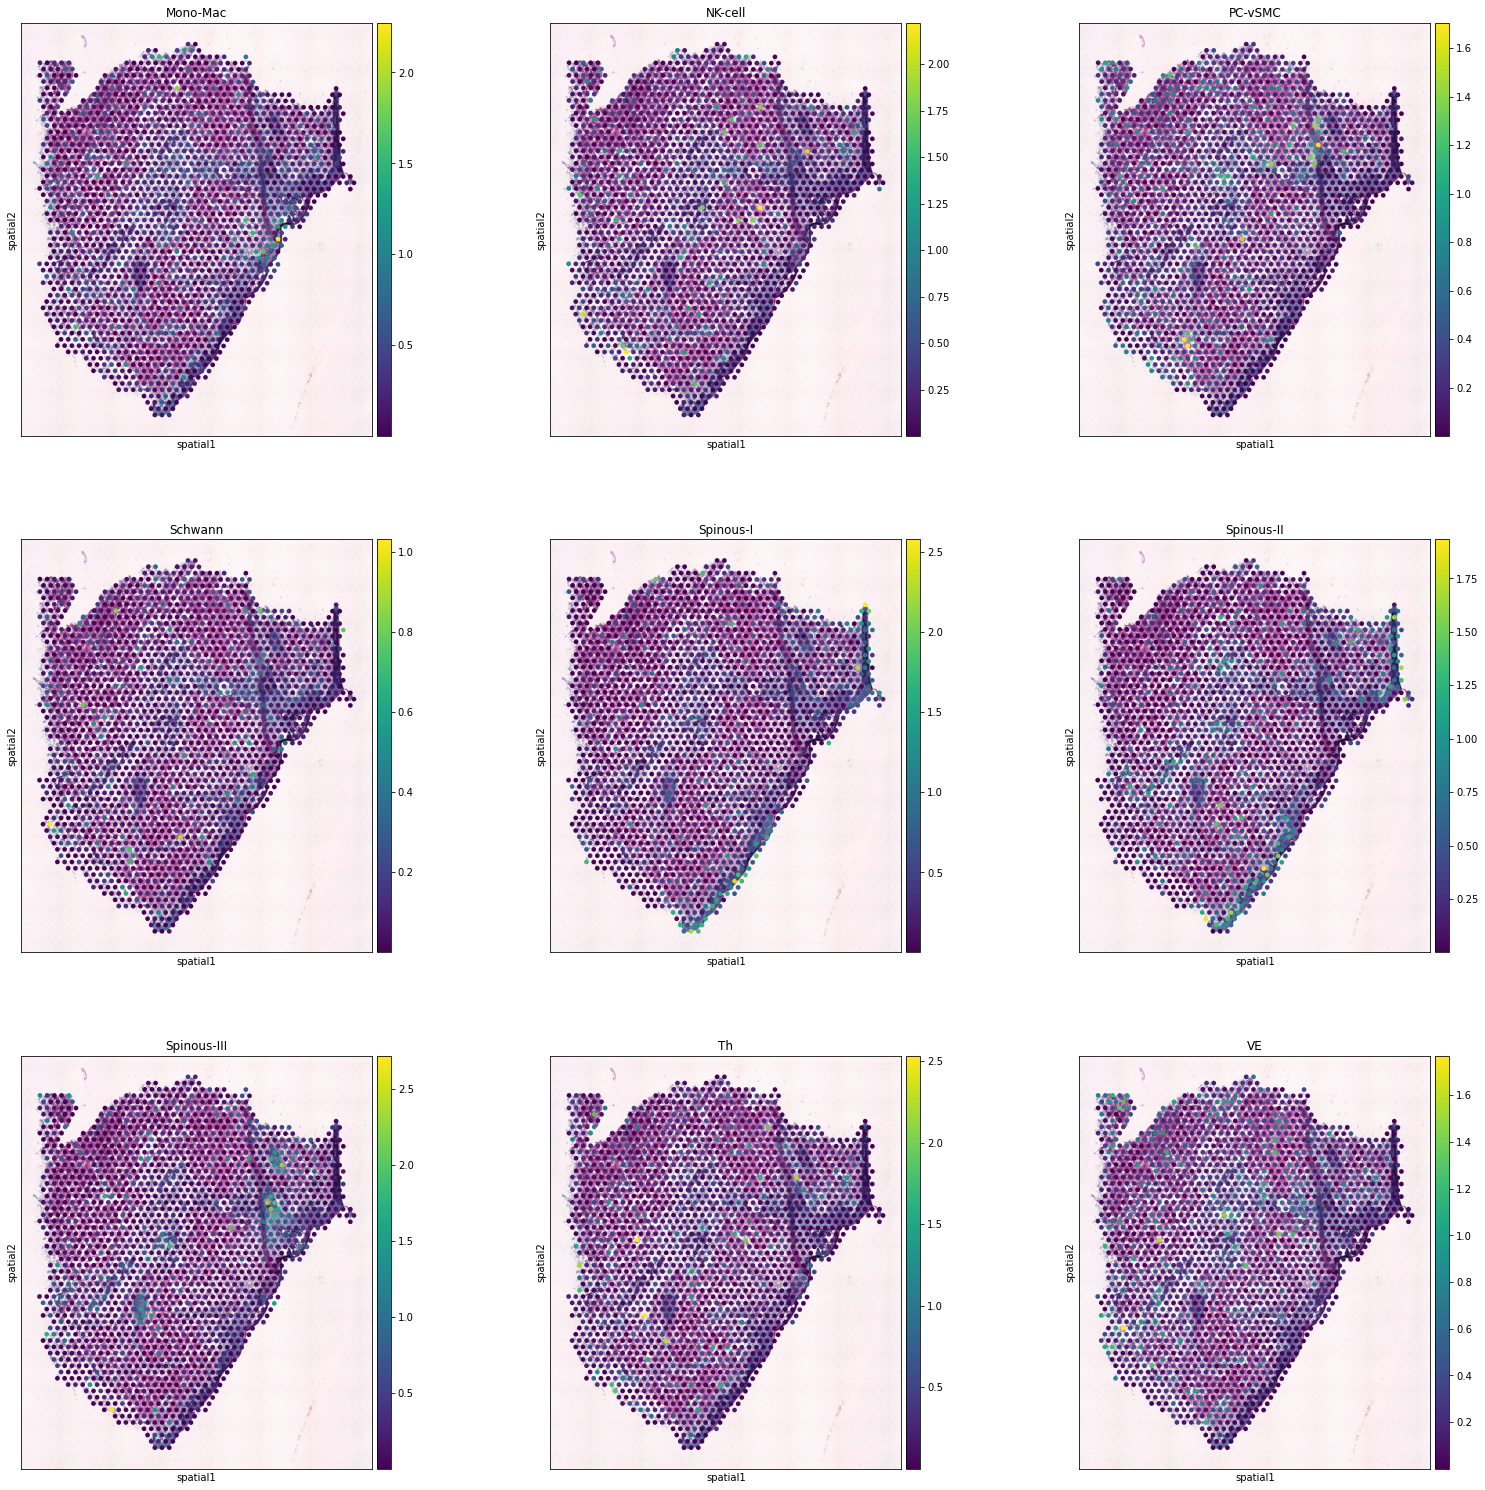

In [21]:
# plot 9 at a time (have 27 celltypes)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[:9],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[9:18],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[18:27],
    ncols=3,
)

In [22]:
adata_st.obsm["tangram_ct_pred"]

Th   Basal-I        DC     FB-II        LE  \
AAACCGGGTAGGTACC-1  0.193102  0.088506  0.000070  0.850922  0.227471   
AAACCGTTCGTCCAGG-1  0.243819  0.128151  0.202367  0.410485  0.099897   
AAACCTCATGAAGTTG-1  0.063090  0.000097  0.000052  0.155272  0.508135   
AAACGAGACGGTTGAT-1  0.000266  0.249393  0.313723  0.000536  0.221864   
AAACGGTTGCGAACTG-1  0.190619  0.518921  0.246832  0.097645  0.006886   
...                      ...       ...       ...       ...       ...   
TTGTTCAGTGTGCTAC-1  0.446896  0.000134  0.000250  0.122222  0.650940   
TTGTTGTGTGTCAAGA-1  0.060278  0.136590  0.152537  0.053390  0.113742   
TTGTTTCACATCCAGG-1  0.000428  0.321552  0.000089  0.180183  0.052696   
TTGTTTCATTAGTCTA-1  0.486332  0.000074  1.050672  0.458656  0.072872   
TTGTTTCCATACAACT-1  0.296843  0.136619  0.000055  0.050579  0.029304   

                         MEL  Mast-cell       Mac  Granular-II    FB-III  ...  \
AAACCGGGTAGGTACC-1  0.158145   0.531504  0.141044     0.090864  0.600127  ...   
AAACCGTTCGTCCAGG-1  0.197978   0.063772  0.200667     0.007449  0.111608  ...   
AAACCTCATGAAGTTG-1  0.228145   0.068100  0.429283     0.000146  0.955021  ...   
AAACGAGACGGTTGAT-1  0.192643   0.137485  0.159940     0.088900  0.050869  ...   
AAACGGTTGCGAACTG-1  0.297945   0.000188  0.000142     0.156644  0.286889  ...   
...                      ...        ...       ...          ...       ...  ...   
TTGTTCAGTGTGCTAC-1  0.068516   0.205775  0.220130     0.050063  0.494668  ...   
TTGTTGTGTGTCAAGA-1  0.173347   0.105138  0.046568     0.065722  0.091094  ...   
TTGTTTCACATCCAGG-1  0.406755   0.278091  0.362166     0.020683  0.300926  ...   
TTGTTTCATTAGTCTA-1  0.046440   0.305121  0.014084     0.103257  0.010626  ...   
TTGTTTCCATACAACT-1  0.701374   0.091127  0.391212     0.065224  0.784061  ...   

                          LC  Spinous-I    B-cell  Basal-II        VE  \
AAACCGGGTAGGTACC-1  0.000042   0.000095  0.454943  0.000082  0.000120   
AAACCGTTCGTCCAGG-1  0.222941   0.000307  0.000312  0.200744  0.640707   
AAACCTCATGAAGTTG-1  0.691982   0.000097  0.048538  0.087606  0.113702   
AAACGAGACGGTTGAT-1  0.250105   0.018011  0.000174  0.247183  0.444755   
AAACGGTTGCGAACTG-1  0.370741   0.477007  0.113910  0.434443  0.111544   
...                      ...        ...       ...       ...       ...   
TTGTTCAGTGTGCTAC-1  0.000124   1.693787  0.000091  0.188245  0.208449   
TTGTTGTGTGTCAAGA-1  0.208518   0.035745  0.011425  0.181147  0.342972   
TTGTTTCACATCCAGG-1  0.000355   0.641753  0.244841  0.148379  0.069960   
TTGTTTCATTAGTCTA-1  0.016766   0.000069  0.039429  0.898944  0.074632   
TTGTTTCCATACAACT-1  0.030686   0.000122  0.501963  0.108070  0.218600   

                     NK-cell  Spinous-III  Basal-IV  Basal-III   Schwann  
AAACCGGGTAGGTACC-1  0.311778     0.153909  0.030225   0.000069  0.000055  
AAACCGTTCGTCCAGG-1  0.012434     0.514841  0.032485   0.150032  0.276134  
AAACCTCATGAAGTTG-1  0.850482     0.114687  0.874141   0.000076  0.062235  
AAACGAGACGGTTGAT-1  0.168281     0.085864  0.019579   0.000299  0.169520  
AAACGGTTGCGAACTG-1  0.138342     0.000304  0.000189   0.204190  0.026908  
...                      ...          ...       ...        ...       ...  
TTGTTCAGTGTGCTAC-1  0.000188     0.000176  0.157634   0.000090  0.180897  
TTGTTGTGTGTCAAGA-1  0.273749     0.494488  0.099498   0.188058  0.285176  
TTGTTTCACATCCAGG-1  0.462656     0.574635  0.148714   0.000233  0.352581  
TTGTTTCATTAGTCTA-1  0.107079     0.041776  0.457433   0.000063  0.085288  
TTGTTTCCATACAACT-1  0.132455     0.028039  0.812382   0.247653  0.118847  

[1725 rows x 27 columns]

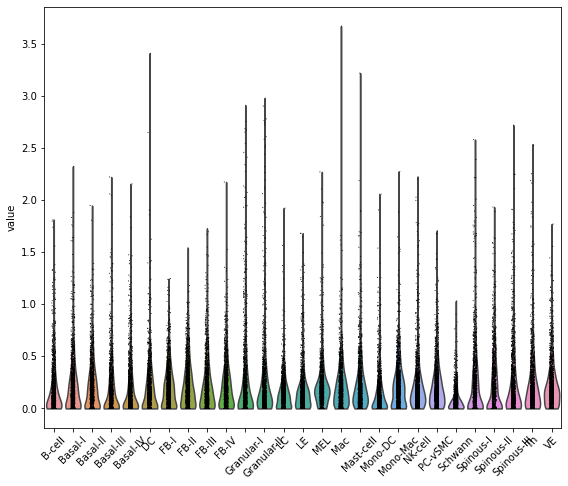

In [23]:
sc.pl.violin(adata_st, celltypes, rotation=45)

Seems like quite a few celltypes get equal prediction around 0.22 per spot. Does it make sense?


# Same but with lognorm

Run same analysis, but run lognorm of the data

In [24]:
sc.pp.log1p(adata_st)
sc.pp.log1p(adata_sc)

In [25]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1555 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:21007 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [26]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    scale=False,
    density_prior='rna_count_based',
    num_epochs=1000,
    device="cpu",
)


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1555 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.315, KL reg: 0.029
Score: 0.476, KL reg: 0.001
Score: 0.482, KL reg: 0.001
Score: 0.483, KL reg: 0.001
Score: 0.484, KL reg: 0.001
Score: 0.484, KL reg: 0.001
Score: 0.484, KL reg: 0.001
Score: 0.485, KL reg: 0.001
Score: 0.485, KL reg: 0.001
Score: 0.485, KL reg: 0.001


INFO:root:Saving results..


In [27]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [28]:
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"tangram_top100_lognorm.csv"))

In [29]:
# add another colame
adata_st.obsm["tangram_ct_pred"].columns += "_ln"
celltypes2 = list(adata_st.obsm["tangram_ct_pred"].columns)

adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


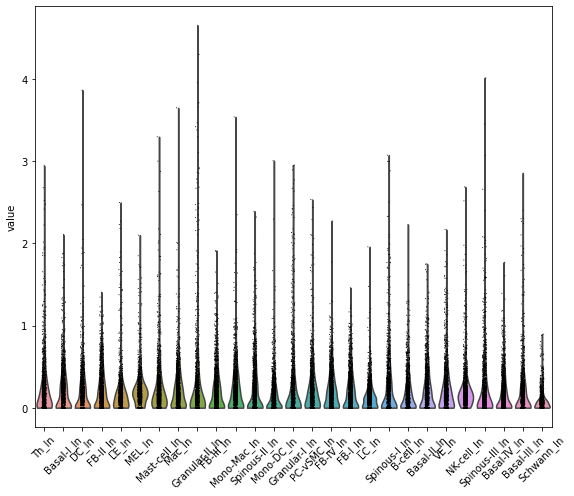

In [30]:
sc.pl.violin(adata_st, celltypes2, rotation=45)

Even more uniform with lognorm

Comments from
https://github.com/broadinstitute/Tangram/issues/3

Applying log-transform
Although applying log(1+x) is critical in computing marker genes, we do not find it essential for mapping. We may, or may not, apply log(1+x). If so, we make sure to apply to both spatial data and scRNAseq data. It is important that both datasets are processed in the same way. 


In tutorial: https://github.com/broadinstitute/Tangram/blob/master/tutorial_sq_tangram.ipynb

They have lognormed data and still use `density_prior='rna_count_based'`

Comments from
https://github.com/broadinstitute/Tangram/issues/3

Mapping on Visium data
If you do not have good prior knowledge of the number of cells in each voxel, then deconvolution using Tangram can be challenging. This is what we usually do:

Rather than inputting a uniform density, we set $\lamba_d = 0$, in order to turn off the density term (the KL divergence term). If we are using the Mapping object, we may or may not turn off the entropy regularizer (usually I see how the entropy looks like w/o regularization). If we are using the MappingConstrained object, we also turn off the count term (which sets a soft constraint for the "total" number of cells), and the filter regularizer.
After mapping, we look at probability maps of cell types and prediction of gene expression of test genes not included in training. If they look OK, we call it a good mapping and start looking at cool things (programs distributed in space, reconstruction of low-quality genes etc). You don't need to deconvolve for achieving this.
If you really want to deconvolve your data, but you do not know about cell number within voxels, you can use MappingConstrained with settings above and manually inspect the learn filters. That would give you a prediction for the "learned" number of cells. We have not documented this case though in the manuscript, and we are unsure about how well it works.

In [31]:
help(tg.map_cells_to_space)

Help on function map_cells_to_space in module tangram.mapping_utils:

map_cells_to_space(adata_sc, adata_sp, cv_train_genes=None, cluster_label=None, mode='cells', device='cpu', learning_rate=0.1, num_epochs=1000, scale=True, lambda_d=0, lambda_g1=1, lambda_g2=0, lambda_r=0, lambda_count=1, lambda_f_reg=1, target_count=None, random_state=None, verbose=True, density_prior='rna_count_based')
    Map single cell data (`adata_sc`) on spatial data (`adata_sp`).
    
    Args:
        adata_sc (AnnData): single cell data
        adata_sp (AnnData): gene spatial data
        cv_train_genes (list): Optional. Training gene list. Default is None.
        cluster_label (str): Optional. Field in `adata_sc.obs` used for aggregating single cell data. Only valid for `mode=clusters`.
        mode (str): Optional. Tangram mapping mode. Currently supported: 'cell', 'clusters', 'constrained'. Default is 'cell'.
        device (string or torch.device): Optional. Default is 'cpu'.
        learning_rate (fl